## Import Libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2

In [2]:
# Dataset paths
TRAIN_DIR = '../dataset/train'
VAL_DIR = '../dataset/validation'

In [3]:
# Image Parameters
BATCH_SIZE = 28
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Dataset Preprocessing

In [4]:
# Rescaling pixel values to [0, 1] for normalization
dataRescale = ImageDataGenerator(rescale=1./255)

# Augmenting training data with transformations
dataAugment = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=(0.7, 1.2),
)

### Load and apply preprocessing

In [5]:
# Creating data generators for train, validation, and test datasets
train_dataset_gen = dataRescale.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_dataset_gen = dataRescale.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Augmenting train dataset for additional variety
train_augmented = dataAugment.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

Found 2560 images belonging to 8 classes.
Found 320 images belonging to 8 classes.
Found 2560 images belonging to 8 classes.


### Convert ImageDataGenerator to tf.data.Dataset

In [6]:
# Function to convert a generator to a TFDS
def generator_to_tf_dataset(generator):
    return tf.data.Dataset.from_generator(
        lambda: (generator[i] for i in range(len(generator))),
        output_types=(tf.float32, tf.float32), 
        output_shapes=(
            (None, IMG_HEIGHT, IMG_WIDTH, 3),
            (None, len(generator.class_indices)) 
        )
    )

In [7]:
# Converting datasets to TensorFlow datasets
train_dataset_augmented = generator_to_tf_dataset(train_augmented)
train_dataset = generator_to_tf_dataset(train_dataset_gen)
val_dataset = generator_to_tf_dataset(val_dataset_gen)

In [8]:
# Combine original and augmented train images
train_dataset = train_dataset.concatenate(train_dataset_augmented)

# Prefetch
train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [9]:
# Displaying a batch of data from the training dataset
for images, labels in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)


Image batch shape: (28, 224, 224, 3)
Label batch shape: (28, 8)


### Visualizing data augmentation results

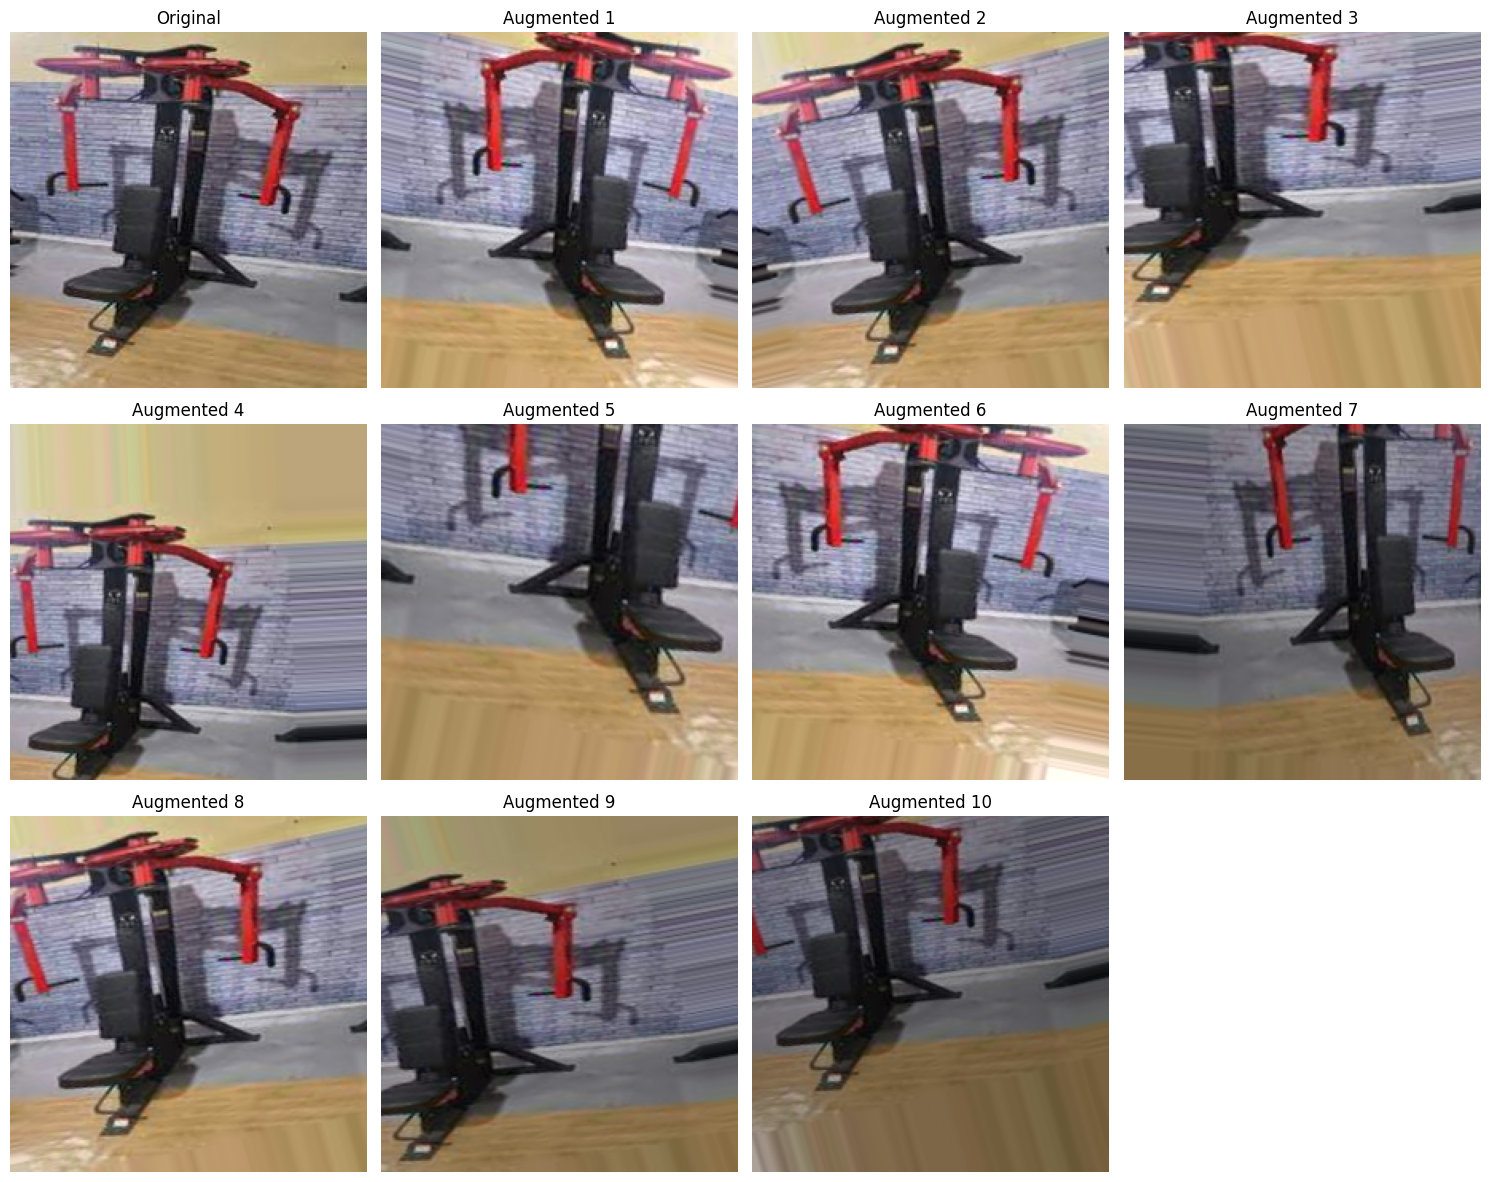

In [10]:
# Augmented sample
image = load_img('../dataset/train/Chest Fly Machine/train_chest_fly_machine12.jpg', target_size=(IMG_HEIGHT, IMG_WIDTH))
image_array = img_to_array(image)
plt.figure(figsize=(15, 12)) 

# Show the original image
plt.subplot(3, 4, 1) 
plt.imshow(image_array.astype('uint8'))
plt.title("Original")
plt.axis('off')

# Prepare the image for augmentation
image_array = np.expand_dims(image_array, axis=0)

# Generate augmented images
augmented_images = dataAugment.flow(image_array, batch_size=1)

# Plot augmented images
for i in range(10):  
    augmented_image_array = next(augmented_images)[0]
    augmented_image_array = np.clip(augmented_image_array, 0, 1)  
    plt.subplot(3, 4, i + 2)
    plt.imshow(augmented_image_array)
    plt.title(f"Augmented {i+1}")
    plt.axis('off')

plt.tight_layout() 
plt.show()

# Modeling

## Load Pre-Trained MobileNetV2 Model

In [11]:
# Load Pre-Trained MobileNetV2 Model
base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.summary(show_trainable=True, expand_nested=True)

Model: "mobilenetv2_1.00_224"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               Y          
                                )]                                                                           
                                                                                                             
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                Y          
                                )                                                                            
                                                                                                             
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']          

## 1. Transfer Learning

In [12]:
# Freeze all layers in the base_model
base_model.trainable = False

In [13]:
# Define the custom model architecture
def custom_model():
    input_layer = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = base_model(input_layer, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.L2(0.02))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.7)(x)
    
    x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.L2(0.02))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.7)(x)
    
    output_layer = tf.keras.layers.Dense(8, activation='softmax', kernel_regularizer=regularizers.L2(0.02))(x)
    
    cust_model = Model(inputs=input_layer, outputs=output_layer)
    return cust_model

In [14]:
# Instantiate and compile the model
model_ft = custom_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_ft.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Define callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=7,              # Stop if val_loss doesn't improve for 7 epochs
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,              # Reduce learning rate by 50%
    patience=3,              # Wait 3 epochs before reducing learning rate
    min_lr=1e-6,             # Set minimum learning rate
    verbose=1
)

history = model_ft.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=120,     
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/120
184/184 [==============================] - 38s 44ms/step - loss: 15.1671 - accuracy: 0.2014 - val_loss: 13.0124 - val_accuracy: 0.5969 - lr: 1.0000e-04
Epoch 2/120
184/184 [==============================] - 28s 33ms/step - loss: 13.7532 - accuracy: 0.3352 - val_loss: 12.0302 - val_accuracy: 0.7375 - lr: 1.0000e-04
Epoch 3/120
184/184 [==============================] - 27s 33ms/step - loss: 12.7365 - accuracy: 0.4377 - val_loss: 11.3286 - val_accuracy: 0.7750 - lr: 1.0000e-04
Epoch 4/120
184/184 [==============================] - 28s 33ms/step - loss: 11.9158 - accuracy: 0.5111 - val_loss: 10.7209 - val_accuracy: 0.8188 - lr: 1.0000e-04
Epoch 5/120
184/184 [==============================] - 28s 33ms/step - loss: 11.1874 - accuracy: 0.5773 - val_loss: 10.1449 - val_accuracy: 0.8344 - lr: 1.0000e-04
Epoch 6/120
184/184 [==============================] - 28s 33ms/step - loss: 10.5315 - accuracy: 0.6125 - val_loss: 9.5969 - val_accuracy: 0.8438 - lr: 1.0000e-04
Epoch 7/120
184/1

In [15]:
# Display model summary
model_ft.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                             

### Plotting Training and Validation Accuracy

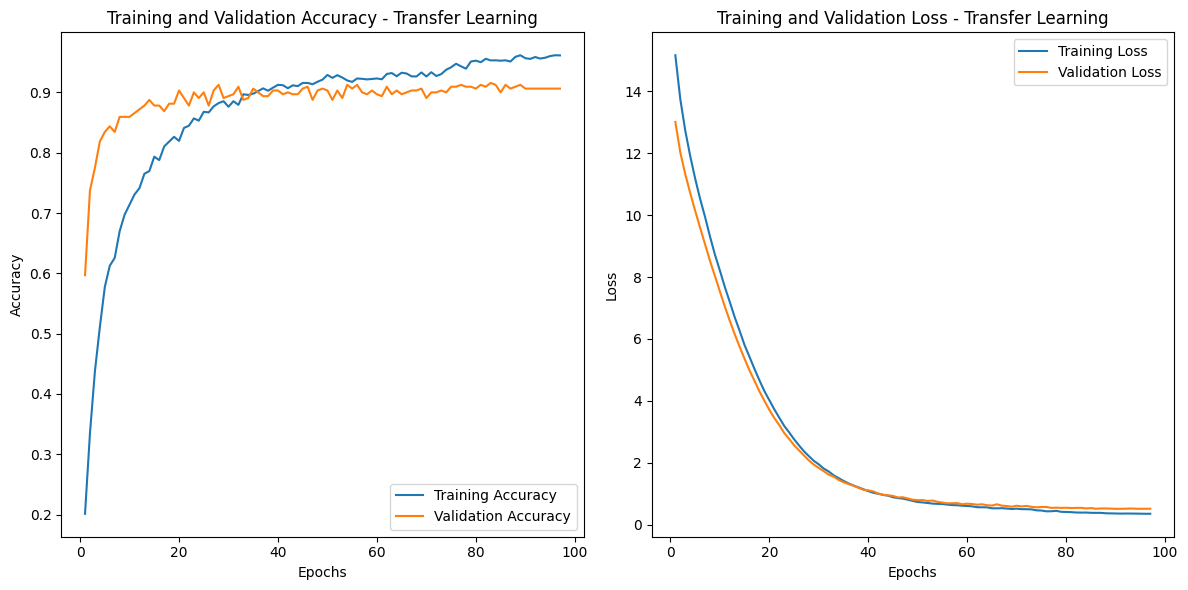

In [16]:
# Extracting data from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Defining the number of epochs
epochs = range(1, len(acc) + 1)

# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy - Transfer Learning')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss - Transfer Learning')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

## 2. Fine-Tuning

In [17]:
# Print the total number of layers in the base model
print("Total number of layers in the base model:", len(base_model.layers))

Total number of layers in the base model: 154


In [18]:
# Unfreeze the base_model for fine-tuning
base_model.trainable = True

In [19]:
fine_tune_at = 100
# Freeze all layers up to the fine_tune_at layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [20]:
# Check which layers are trainable
print("Layers that are trainable after fine-tuning:")
for layer in base_model.layers:
    print(f"{layer.name}: {'Trainable' if layer.trainable else 'Frozen'}")

Layers that are trainable after fine-tuning:
input_1: Frozen
Conv1: Frozen
bn_Conv1: Frozen
Conv1_relu: Frozen
expanded_conv_depthwise: Frozen
expanded_conv_depthwise_BN: Frozen
expanded_conv_depthwise_relu: Frozen
expanded_conv_project: Frozen
expanded_conv_project_BN: Frozen
block_1_expand: Frozen
block_1_expand_BN: Frozen
block_1_expand_relu: Frozen
block_1_pad: Frozen
block_1_depthwise: Frozen
block_1_depthwise_BN: Frozen
block_1_depthwise_relu: Frozen
block_1_project: Frozen
block_1_project_BN: Frozen
block_2_expand: Frozen
block_2_expand_BN: Frozen
block_2_expand_relu: Frozen
block_2_depthwise: Frozen
block_2_depthwise_BN: Frozen
block_2_depthwise_relu: Frozen
block_2_project: Frozen
block_2_project_BN: Frozen
block_2_add: Frozen
block_3_expand: Frozen
block_3_expand_BN: Frozen
block_3_expand_relu: Frozen
block_3_pad: Frozen
block_3_depthwise: Frozen
block_3_depthwise_BN: Frozen
block_3_depthwise_relu: Frozen
block_3_project: Frozen
block_3_project_BN: Frozen
block_4_expand: Froz

In [21]:
# Recompile the model with a lower learning rate
model_ft.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [22]:
# Continue training the model with fine-tuning
history_fine = model_ft.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,                      
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/30
184/184 [==============================] - 32s 47ms/step - loss: 0.6047 - accuracy: 0.8721 - val_loss: 0.4569 - val_accuracy: 0.9062 - lr: 1.0000e-04
Epoch 2/30
184/184 [==============================] - 29s 43ms/step - loss: 0.4301 - accuracy: 0.9279 - val_loss: 0.5962 - val_accuracy: 0.8938 - lr: 1.0000e-04
Epoch 3/30
184/184 [==============================] - 29s 43ms/step - loss: 0.3640 - accuracy: 0.9516 - val_loss: 0.4090 - val_accuracy: 0.9344 - lr: 1.0000e-04
Epoch 4/30
184/184 [==============================] - 28s 43ms/step - loss: 0.3379 - accuracy: 0.9586 - val_loss: 0.4623 - val_accuracy: 0.9031 - lr: 1.0000e-04
Epoch 5/30
184/184 [==============================] - 29s 43ms/step - loss: 0.3194 - accuracy: 0.9627 - val_loss: 0.4379 - val_accuracy: 0.9250 - lr: 1.0000e-04
Epoch 6/30
183/184 [============================>.] - ETA: 0s - loss: 0.2851 - accuracy: 0.9721
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
184/184 [==============

In [23]:
# Display model summary after fine-tuning
model_ft.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                             

### Plotting Training and Validation Accuracy

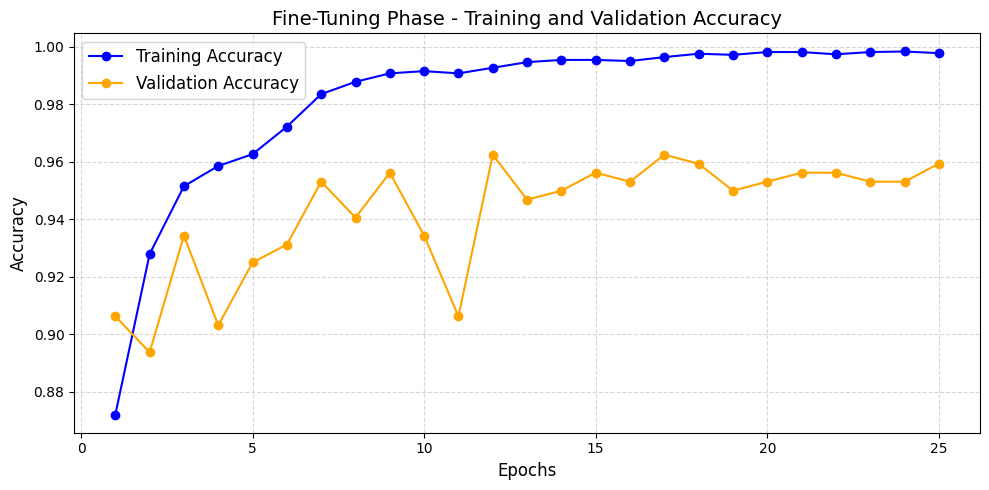

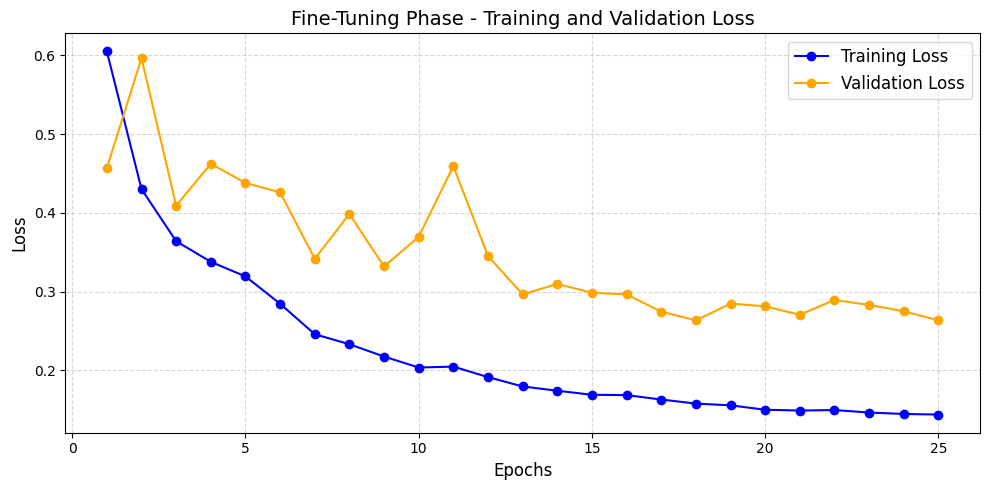

In [24]:
# Plotting Training and Validation Accuracy for Fine-Tuning
fine_tune_acc = history_fine.history['accuracy']
fine_tune_val_acc = history_fine.history['val_accuracy']
fine_tune_epochs = range(1, len(fine_tune_acc) + 1)

plt.figure(figsize=(10, 5))
plt.plot(fine_tune_epochs, fine_tune_acc, label='Training Accuracy', color='blue', marker='o')
plt.plot(fine_tune_epochs, fine_tune_val_acc, label='Validation Accuracy', color='orange', marker='o')
plt.title('Fine-Tuning Phase - Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plotting Training and Validation Loss for Fine-Tuning
fine_tune_loss = history_fine.history['loss']
fine_tune_val_loss = history_fine.history['val_loss']
fine_tune_epochs = range(1, len(fine_tune_loss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(fine_tune_epochs, fine_tune_loss, label='Training Loss', color='blue', marker='o')
plt.plot(fine_tune_epochs, fine_tune_val_loss, label='Validation Loss', color='orange', marker='o')
plt.title('Fine-Tuning Phase - Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Combine Plotting Training and Validation Accuracy

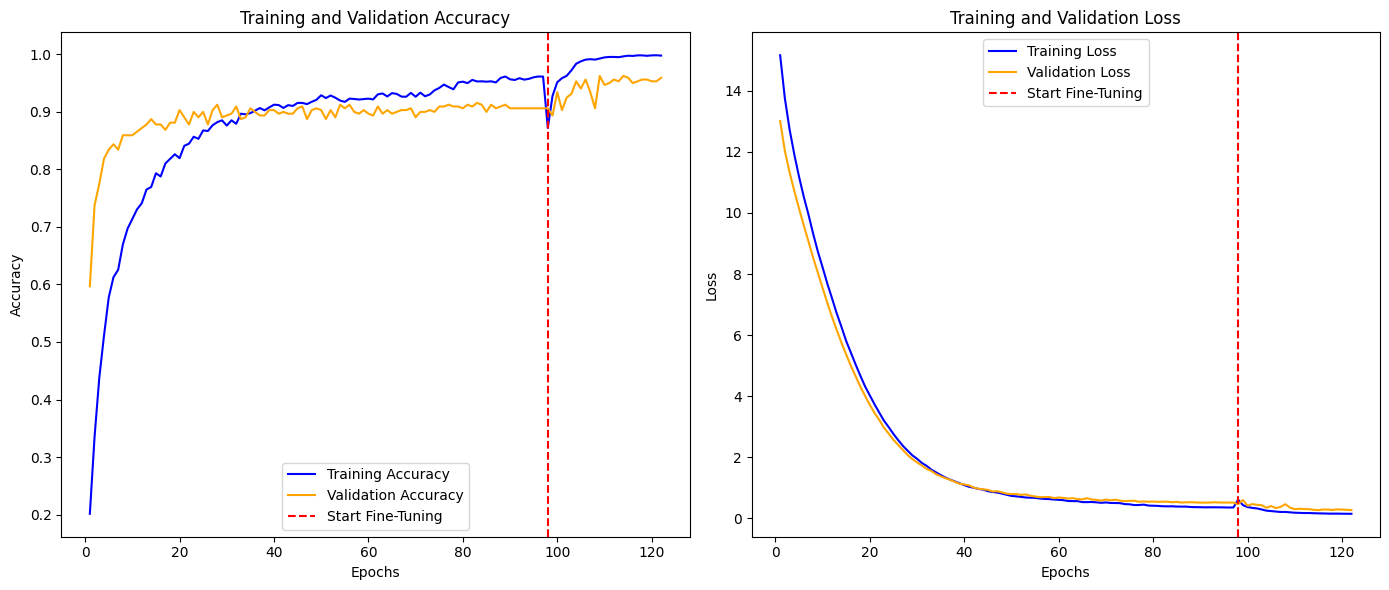

In [25]:
# Combine histories
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

total_epochs = range(1, len(acc) + 1)
fine_tuning_start_epoch = len(history.history['accuracy']) + 1

# Plotting
plt.figure(figsize=(14, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(total_epochs, acc, label='Training Accuracy', color='blue')
plt.plot(total_epochs, val_acc, label='Validation Accuracy', color='orange')
plt.axvline(x=fine_tuning_start_epoch, color='red', linestyle='--', label='Start Fine-Tuning')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(total_epochs, loss, label='Training Loss', color='blue')
plt.plot(total_epochs, val_loss, label='Validation Loss', color='orange')
plt.axvline(x=fine_tuning_start_epoch, color='red', linestyle='--', label='Start Fine-Tuning')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Save Model

In [26]:
model_ft.save('../model/model_ft_finetuned.h5')

## Convert Model

In [4]:
import tensorflow as tf
import pathlib

# Load the pre-trained model from .h5 format
model = tf.keras.models.load_model('../model/model_ft_finetuned.h5')

# Save the model in TensorFlow SavedModel format for conversion
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

# Initialize TFLite converter
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Convert the model to TensorFlow Lite format
tflite_model = converter.convert()

# Save the TFLite model to file
tflite_model_file = pathlib.Path('../model/gym_equip_classifier.tflite')
tflite_model_file.write_bytes(tflite_model)

# Print the saved model's location
print(f"Model saved at: {tflite_model_file}")


INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


Model saved at: ..\model\gym_equip_classifier.tflite
